In [49]:
import ROOT
import ctypes

In [50]:
sig_file = ROOT.TFile.Open("/media/jykim/T7/storage/01_recon/phi/D0_massveto_v2_half_1_sig_ext_signalMC_recon_mdst_phi.root")
signal_tree = sig_file.Get("phi")


In [51]:
D0_M_TH1F = ROOT.TH1F("D0_M_TH1F","D0 mass",50,1.67,2.06)


In [52]:
def extract_histo(tree, histogram):
    for event in tree:
        histogram.Fill(event.D0_M)
    return histogram

In [53]:
def apply_cuts(tree, histogram):
    for event in tree:
        if event.D0_M > 1.67 and event.D0_M < 2.06:
            histogram.Fill(event.D0_M)
    return histogram

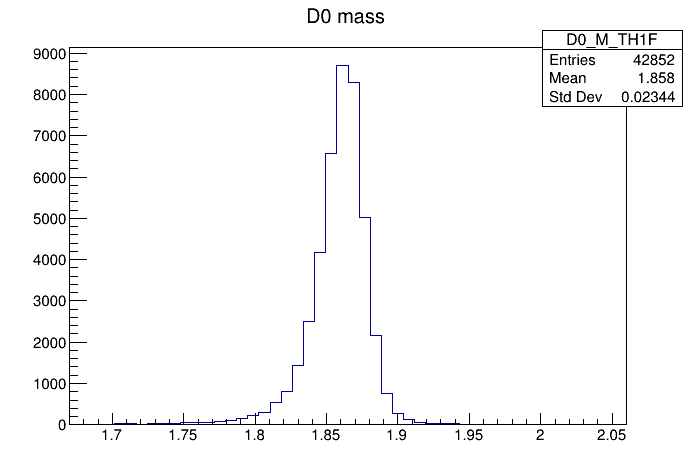

In [54]:

D0_M_TH1F = apply_cuts(signal_tree, D0_M_TH1F)
c1 = ROOT.TCanvas()
D0_M_TH1F.Draw()
c1.Draw()

In [55]:
fitting_region = (1.67, 2.06)
x = ROOT.RooRealVar("M(D^{0})", "M(D^{0}) [GeV/c^{2}]", fitting_region[0], fitting_region[1], "")
# x.setBins(50)
l = ROOT.RooArgList(x)
signalhist = ROOT.RooDataHist("sighist", "sighist", l, D0_M_TH1F, 0.1)


In [56]:

mean = ROOT.RooRealVar("mean", "mean of gaussians", 1.86,1.83, 1.89)
sigma1 = ROOT.RooRealVar("sigma1", "width of gaussians", 0.03,0,0.5)
sigma2 = ROOT.RooRealVar("sigma2", "width of gaussians", 0.05,0,0.5)
alpha = ROOT.RooRealVar("alpha", "width of gaussians", 0.5,0,20)
n_CB = ROOT.RooRealVar("n_CB", "width of gaussians", 20,0,100)
 
# Novo_peak = ROOT.RooRealVar("Novo_peak", "Novo peak", 1.83,1.67,1.93)    
# Novo_width = ROOT.RooRealVar("Novo_widh", "Novo peak", 0.05,0,0.5)    
# Novo_tail = ROOT.RooRealVar("Novo_tail", "Novo peak", 0.5,0,10)    




[#0] WARNING:InputArguments -- The parameter 'sigma1' with range [0, 0.5] of the RooGaussian 'sig1' exceeds the safe range of (0, inf). Advise to limit its range.
[#0] WARNING:InputArguments -- RooAbsPdf::fitTo(model) WARNING: a likelihood fit is requested of what appears to be weighted data.
       While the estimated values of the parameters will always be calculated taking the weights into account,
       there are multiple ways to estimate the errors of the parameters. You are advised to make an 
       explicit choice for the error calculation:
           - Either provide SumW2Error(true), to calculate a sum-of-weights-corrected HESSE error matrix
             (error will be proportional to the number of events in MC).
           - Or provide SumW2Error(false), to return errors from original HESSE error matrix
             (which will be proportional to the sum of the weights, i.e., a dataset with <sum of weights> events).
           - Or provide AsymptoticError(true), to use the 

Warning in <TCanvas::Constructor>: Deleting canvas with same name: Canvas
Info in <TCanvas::Print>: png file test.png has been created


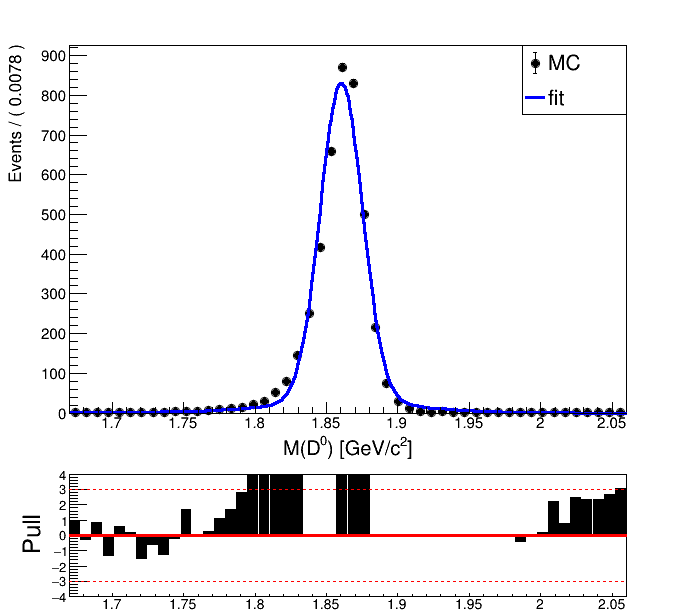

In [61]:
canv = ROOT.TCanvas("Canvas", "Canvas", 700, 640)

xlow = ctypes.c_double()
ylow = ctypes.c_double()
xup = ctypes.c_double()
yup = ctypes.c_double()

canv.GetPad(0).GetPadPar(xlow, ylow, xup, yup)
canv.Divide(1,2)

xlow = xlow.value
ylow = ylow.value
xup = xup.value
yup = yup.value

upPad = canv.GetPad(1)
upPad.SetPad(xlow, ylow+0.25*(yup-ylow),xup,yup)

dwPad = canv.GetPad(2)
dwPad.SetPad(xlow, ylow,xup,ylow+0.25*(yup-ylow))

    
sig1 = ROOT.RooGaussian("sig1", "Signal component 1", x, mean, sigma1)
sig2 = ROOT.RooCBShape("sig2", "Signal component 2", x, mean, sigma2, alpha, n_CB)
# sig3 = ROOT.RooNovosibirsk("sig3", "Signal component 3", x, mean, Novo_width, Novo_tail)


sig1frac = ROOT.RooRealVar("sig1frac", "fraction of component 1 in signal", 0.5, 0.0, 1.0)
model = ROOT.RooAddPdf("model", "model", [sig1, sig2], sig1frac)


r = model.fitTo(signalhist,NumCPU=12,Range=fitting_region,PrintLevel=-1, Save=1)

r.Print()
canv.cd(1) 
# frame = x.frame(Title="D^{0} #rightarrow #bar{K}^{*0} #pi^{0}")
frame = x.frame(Title=" ")

signalhist.plotOn(frame,Name = "data1", XErrorSize=0)

# sig.plotOn(frame, Name="gauss1", Components=sig1, LineStyle=ROOT.kDashed, LineColor=593)
# sig.plotOn(frame, Name="CB1", Components=sig2, LineStyle=ROOT.kDashed, LineColor=593)
# sig.plotOn(frame, Name="Novo", Components=sig3, LineStyle=ROOT.kDashed, LineColor=593)

model.plotOn(frame, Name="fitting",)


# sig.paramOn(frame)
frame.GetXaxis().SetTitleSize(0.047)
frame.GetXaxis().CenterTitle(True)
frame.GetYaxis().SetTitleSize(0.04)
frame.GetYaxis().SetTitleOffset(1.2)
frame.Draw("PE")


leg1 = ROOT.TLegend(0.75, 0.75, 0.9, 0.9)
leg1.SetFillColor(ROOT.kWhite)
# leg1.SetHeader("The Legend title","C")
leg1.AddEntry("data1", "MC", "PE")
leg1.AddEntry("fitting", "fit", "l")
leg1.Draw()

hpull = frame.pullHist()
hpull.SetFillStyle(1001)
hpull.SetFillColor(1);
for i in range(0,hpull.GetN()):#(int i=0;i<hpull.GetN();++i): 
    hpull.SetPointError(i,0.0,0.0,0.0,0.0)
# pullplot = x.frame(Title(" "))
pullplot = x.frame()
pullplot.SetTitle("")
pullplot.addPlotable(hpull,"BE")
# pullplot.addPlotable(hpull,"PE")

pullplot.SetYTitle("Pull")
pullplot.GetXaxis().SetTitleSize(0)
pullplot.GetYaxis().SetTitleSize(0.17)
pullplot.GetYaxis().CenterTitle(True)
pullplot.GetYaxis().SetTitleOffset(0.2)
pullplot.SetMinimum(-4.)
pullplot.SetMaximum(4.)
pullplot.GetXaxis().SetLabelSize(0.1)
pullplot.GetYaxis().SetLabelSize(0.09)
canv.cd(2)
pullplot.Draw()

xmin1 = ctypes.c_double(fitting_region[0])
xmax1 = ctypes.c_double(fitting_region[1])
# xmin1 = 0.1
# xmax1 = 0.18
line = ROOT.TLine(xmin1,0.0,xmax1,0.0)
line1 = ROOT.TLine(xmin1,3.0,xmax1,3.0)
line2 = ROOT.TLine(xmin1,-3.0,xmax1,-3.0)

line.SetLineColor(ROOT.kRed)
line.SetLineWidth(3)
line1.SetLineColor(ROOT.kRed)
line2.SetLineColor(ROOT.kRed)
line1.SetLineStyle(2)
line2.SetLineStyle(2)
line.Draw("SAME")
line1.Draw("SAME")
line2.Draw("SAME")

canv.Update()

canv.Draw()
canv.SaveAs("test.png")

f = ROOT.TFile("phig_signalMC_fitresult.root", "RECREATE")
r.Write("phig_sig")
f.Close()


In [69]:
model.Print("t")

0x563da30f8d20 RooAddPdf::model = 0.958309 [Auto,Dirty] 
  0x563d9ab46480/V- RooGaussian::sig1 = 0.953833 [Auto,Dirty] 
    0x563da18ac2d0/V- RooRealVar::M(D^{0}) = 1.865
    0x563d9a860790/V- RooRealVar::mean = 1.86044 +/- 0.000266339
    0x563d9b80fb70/V- RooRealVar::sigma1 = 0.0148181 +/- 0.000287594
  0x563d9e1ce2b0/V- RooRealVar::sig1frac = 0.894618 +/- 0.0122615
  0x563da05bb920/V- RooCBShape::sig2 = 0.996305 [Auto,Dirty] 
    0x563da18ac2d0/V- RooRealVar::M(D^{0}) = 1.865
    0x563d9a860790/V- RooRealVar::mean = 1.86044 +/- 0.000266339
    0x563da0102970/V- RooRealVar::sigma2 = 0.0529465 +/- 0.00357489
    0x563d9d58fc40/V- RooRealVar::alpha = 1.67765 +/- 0.431595
    0x563d99ccb390/V- RooRealVar::n_CB = 1.26685 +/- 1.88685


In [63]:
f = ROOT.TFile.Open("phig_signalMC_fitresult.root")
r2 = ROOT.gDirectory.Get("phig_sig")
f.Close()


In [70]:
r2.Print()


  RooFitResult: minimized FCN value: -10816.6, estimated distance to minimum: 4.14871e-05
                covariance matrix quality: Full, accurate covariance matrix
                Status : MINIMIZE=0 HESSE=0 

    Floating Parameter    FinalValue +/-  Error   
  --------------------  --------------------------
                 alpha    1.6776e+00 +/-  4.32e-01
                  mean    1.8604e+00 +/-  2.66e-04
                  n_CB    1.2668e+00 +/-  1.89e+00
              sig1frac    8.9462e-01 +/-  1.23e-02
                sigma1    1.4818e-02 +/-  2.88e-04
                sigma2    5.2946e-02 +/-  3.57e-03



In [87]:
r2.correlation("alpha","mean")

0.017036156591536362

In [89]:
r2.edm()

4.148708183205684e-05

In [95]:
r2.correlationMatrix()

<cppyy.gbl.TMatrixTSym<double> object at 0x563d9f6a8200>